# Analyzing the UncertaintyForest Class by Reproducing Posterior Estimates

If you haven't seen it already, take a look at other tutorials to setup and install the ProgLearn package: `installation_guide.ipynb`.

*Goal: Run the UncertaintyForest class to produce a figure that compares estimated posteriors for the UncertaintyForest, CART, and IRF algorithms, as in Figure 1 from [this paper](https://arxiv.org/pdf/1907.00325.pdf)*

## Import Required Packages

In [80]:
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from joblib import Parallel, delayed
from collections import defaultdict
from sklearn.utils.fixes import _joblib_parallel_args
import threading
from sklearn.ensemble._base import _partition_estimators
from sklearn.utils.validation import check_is_fitted
from sklearn import datasets

import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_context("paper", font_scale=1.5)   

from sklearn.utils.validation import check_X_y, check_array
from sklearn.tree import DecisionTreeClassifier

from tqdm.notebook import tqdm
from scipy.stats import entropy, norm, multivariate_normal

from random import sample


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Specify Parameters

In [82]:
# Here are the paper reproduction parameters
#n = 6000
#mean = 1
#var = 1
#num_trials = 100 
#X_eval = np.linspace(-2, 2, num = 30).reshape(-1, 1)
#n_estimators = 300
#num_plotted_trials = 10

# Here are the scaled-down tutorial parameters
n = 300 # number of data points
mean = 1 # mean of the data
var = 1 # variance of the data
num_trials = 3 # number of trials to run
X_eval = np.linspace(-2, 2, num = 10).reshape(-1, 1) # the evaluation span (over X) for the plot
n_estimators = 100 # the number of estimators
num_plotted_trials = 2 # the number of "fainter" lines to be displayed on the figure

In [83]:
# Updates to UncertaintyForest class based on sklearn: Ronan Perry (NeuroData Lab, 2021)
class UncertaintyForest:
    """
    A class used to represent an Uncertainty Forest.

    Parameters
    ----------
    n_estimators : int, default=100
        The number of trees in the UncertaintyForest

    kappa : float, default=np.inf
        The coefficient for finite sample correction. If set to the default
        value, finite sample correction is not performed.

    max_depth : int, default=None
        The maximum depth of a tree in the UncertaintyForest.

    tree_construction_proportion : float, default=0.5
        The proportions of the input data set aside to train each decision
        tree. The remainder of the data is used to fill in voting posteriors.

    max_features : {"auto", "sqrt", "log2"}, int or float, default="auto"
        The number of features to consider when looking for the best split:
        - If int, then consider `max_features` features at each split.
        - If float, then `max_features` is a fraction and
          `round(max_features * n_features)` features are considered at each
          split.
        - If "auto", then `max_features=sqrt(n_features)`.
        - If "sqrt", then `max_features=sqrt(n_features)` (same as "auto").
        - If "log2", then `max_features=log2(n_features)`.
        - If None, then `max_features=n_features`.

        Note: the search for a split does not stop until at least one
        valid partition of the node samples is found, even if it requires to
        effectively inspect more than ``max_features`` features.

    poisson_sampler : boolean, default=False
        To match the GRF theory [#1grf]_, if True, the number of features
        considered at each tree are drawn from a poisson distribution with
        mean equal to `max_features`.

    n_jobs : int, default=None
        The number of jobs to run in parallel. ``-1`` means use all
        processors. None equates to 1.

    max_samples : int or float, default=None
        The number of samples to draw from X (without replacement) to train
        each tree.
        - If None, then draw `X.shape[0]` samples.
        - If int, then draw `max_samples` samples.
        - If float, then draw `max_samples * X.shape[0]` samples. Thus,
          `max_samples` should be in the interval `(0, 1)`.

        Note: The number of samples used to learn the tree will be further
        reduced per the `tree_construction_proportion` value.

    honest_prior : {"ignore", "uniform", "empirical"}, default="ignore"
        Method for dealing with empty leaves during evaluation of a test
        sample. If "ignore", trees in which the leaf is empty are not used in
        the prediction. If "uniform", the prior tree posterior is 1/(number of
        classes). If "empirical", the prior tree posterior is the relative
        class frequency in the voting subsample. If all tree leaves are empty,
        "ignore" will use the empirical prior and the others will use their
        respective priors.

    tree_kwargs : dict, default={}
        Named arguments to be passed to each
        sklearn.tree.DecisionTreeClassifier tree used in the construction
        of the forest in addition to the above parameters.

    Attributes
    ----------
    transformers_ : list of sklearn.tree.DecisionTreeClassifier
        The collection of fitted trees.

    voters_ : list of proglearn.voter.TreeClassificationVoter
        The collection of honest voters for leaves in matching trees in
        `self.estimators_` at the same index.

    n_features_ : int
        The number of features when `fit` is performed.

    tree_kwargs_ : dict
        Full set of keyword arguments passed to the Forest transformer.

    References
    ----------
    .. [#1grf] Athey, Susan, Julie Tibshirani and Stefan Wager.
        "Generalized Random Forests", Annals of Statistics, 2019.
    """

    def __init__(
        self,
        n_estimators=100,
        kappa=np.inf,
        max_depth=None,
        tree_construction_proportion=0.63,
        max_features="auto",
        poisson_sampler=False,
        max_samples=None,
        n_jobs=None,
        honest_prior="ignore",
        weighted_trees=False,
        tree_kwargs={},
    ):
        self.n_estimators = n_estimators
        self.kappa = kappa
        self.max_depth = max_depth
        self.tree_construction_proportion = tree_construction_proportion
        self.max_features = max_features
        self.poisson_sampler = poisson_sampler
        self.max_samples = max_samples
        self.n_jobs = n_jobs
        self.tree_kwargs = tree_kwargs
        self.honest_prior = honest_prior
        self.verbose = 0
        self.weighted_trees = weighted_trees

    def fit(self, X, y):
        """
        fits forest to data X with labels y

        Parameters
        ----------
        X : array of shape [n_samples, n_features]
            The data that will be trained on

        y : array of shape [n_samples]
            The label for cluster membership of the given data

        Returns
        -------
        self : UncertaintyForest
            The object itself.
        """
        X, y = check_X_y(X, y)

        self.n_samples_, self.n_features_ = X.shape
        self.n_classes_ = len(np.unique(y))
        self.empirical_prior_ = np.bincount(y, minlength=self.n_classes_) / len(y) # Note: throws an error if data is -1, 1 (negative list values) rather than 0, 1

        self.transformers_ = [
            DecisionTreeClassifier(
                max_features = self.max_features,
                max_depth = self.max_depth)
            for _ in range(self.n_estimators)
        ]

        # Source https://github.com/scikit-learn/scikit-learn/blob/95119c13a/sklearn/ensemble/_forest.py#L387
        self.transformers_, self.transformer_indices_ = list(zip(
            *Parallel(n_jobs=self.n_jobs, verbose=self.verbose, **_joblib_parallel_args(prefer="threads"))(
                delayed(_parallel_build_trees)(
                    X, y, tree, self.n_samples_, self.n_classes_,
                    self.honest_prior, self.tree_construction_proportion,
                    self.kappa, self.weighted_trees)
                for tree in self.transformers_)
                )) 
        
        return self

    def predict_proba(self, X):
        """
        estimates class posteriors for each example in input data X.

        Parameters
        ----------
        X : array of shape [n_samples, n_features]
            The data whose posteriors we are estimating.

        Returns
        -------
        y_proba_hat : ndarray of shape [n_samples, n_classes]
            posteriors per example
        """
        X = self._validate_X_predict(X)
        n_jobs, _, _ = _partition_estimators(self.n_estimators, self.n_jobs)

        # avoid storing the output of every estimator by summing them here
        posteriors = np.zeros((X.shape[0], self.n_classes_), dtype=np.float64)
        lock = threading.Lock()

        Parallel(n_jobs=n_jobs, verbose=self.verbose, **_joblib_parallel_args(require="sharedmem"))(
            delayed(_accumulate_prediction)(tree.tree_.predict, X, posteriors, lock, None,
            self.weighted_trees)
            for tree in self.transformers_)

        # Normalize to unit length, due to prior weighting
        zero_mask = posteriors.sum(1) == 0
        posteriors[~zero_mask] /= posteriors[~zero_mask].sum(1, keepdims=True)
        posteriors[zero_mask] = self.empirical_prior_

        return posteriors

    def _validate_X_predict(self, X):
        """
        From sklearn
        Validate X whenever one tries to predict, apply, predict_proba."""
        check_is_fitted(self)

        return self.transformers_[0]._validate_X_predict(X, check_input=True)

    def predict(self, X):
        """
        predicts class labels for each example in input data X.

        Parameters
        ----------
        X : array of shape [n_samples, n_features]
            The data on which we are performing inference.

        Returns
        -------
        y_hat : ndarray of shape [n_samples]
            predicted class label per example
        """
        return self.predict_proba(X).argmax(1)

    def predict_proba_honest(self, X):
        """
        Returns predicted posteriors of the training data, excluding trees a
        sample was used in construction of.

        Parameters
        ----------
        X : array of shape [n_samples, n_features]
            The data on which the forest was fit to.

        Returns
        -------
        y_proba_hat : ndarray of shape [n_samples, n_classes]
            posteriors per example
        """
        X = self._validate_X_predict(X)
        n_jobs, _, _ = _partition_estimators(self.n_estimators, self.n_jobs)

        # avoid storing the output of every estimator by summing them here
        posteriors = np.zeros((X.shape[0], self.n_classes_), dtype=np.float64)
        lock = threading.Lock()

        Parallel(n_jobs=n_jobs, verbose=self.verbose, **_joblib_parallel_args(require="sharedmem"))(
            delayed(_accumulate_prediction)(tree.tree_.predict, X, posteriors, lock, honest_indices)
            for tree, honest_indices in zip(self.transformers_, self.voter_indices_))

        # Normalize to unit length, due to prior weighting
        zero_mask = posteriors.sum(1) == 0
        posteriors[~zero_mask] /= posteriors[~zero_mask].sum(1, keepdims=True)
        posteriors[zero_mask] = self.empirical_prior_

        return posteriors


    @property
    def voter_indices_(self):
        if not hasattr(self, "transformer_indices_"):
            raise AttributeError("Model has not been fitted. Please fit first.")
        return [
            np.setdiff1d(np.arange(self.n_samples_), transformer_indices)
            for transformer_indices in self.transformer_indices_]


def _parallel_build_trees(
    X, y, tree, n_samples_, n_classes_,
    honest_prior, tree_construction_proportion,
    kappa, weighted_trees):
        # https://github.com/scikit-learn/scikit-learn/blob/95119c13a/sklearn/ensemble/_forest.py#L140
        """
        Private function used to fit a single tree in parallel."""

        transformer_indices = np.random.choice(
            n_samples_,
            int(tree_construction_proportion * n_samples_),
            replace=False)  # No bootstrapping
        voter_indices = np.setdiff1d(
            np.arange(n_samples_), transformer_indices)

        sample_weight = np.ones((n_samples_,), dtype=np.float64)
        sample_counts = np.bincount(
            transformer_indices, minlength=n_samples_)
        sample_weight *= sample_counts

        tree.fit(X, y, sample_weight=sample_weight, check_input=False)

        honest_leaves = tree.apply(X[voter_indices])
        
        tree.tree_.value[:, :, :] = 0 # empirical_prior

        for leaf_id, yval in zip(honest_leaves, y[voter_indices]):
            tree.tree_.value[leaf_id][0, yval] += 1

        return tree, transformer_indices


def _accumulate_prediction(predict, X, out, lock, honest_indices=None, weighted_trees=False):
    """
    See https://github.com/scikit-learn/scikit-learn/blob/95119c13af77c76e150b753485c662b7c52a41a2/sklearn/ensemble/_forest.py#L460

    This is a utility function for joblib's Parallel.
    It can't go locally in ForestClassifier or ForestRegressor, because joblib
    complains that it cannot pickle it when placed there.
    """

    # predict = DecisionTreeClassifier.tree_.predict
    if honest_indices is not None:
        proba = predict(X[honest_indices])
    else:
        proba = predict(X)
    if not weighted_trees:
        zero_mask = proba.sum(1) == 0
        proba[~zero_mask] /= proba[~zero_mask].sum(1, keepdims=True)
    with lock:
        if honest_indices is not None:
            out[honest_indices] += proba
        else:
            out += proba

In [84]:
def generate_data_newUF(n, mean, var):
    '''
    Parameters
    ---
    n : int
        The number of data to be generated
    mean : double
        The mean of the data to be generated
    var : double
        The variance in the data to be generated
    '''
    y = np.random.binomial(1, .5, n) # classes are 0 and 1. #UPDATED
    X = np.random.normal(mean * (2*y - 1), np.sqrt(var), (1, n)).T
    
    return X, y

def estimate_posterior_newUF(algo, n, mean, var, num_trials, X_eval, parallel = False):
    '''
    Estimate posteriors for many trials and evaluate in the given X_eval range
    
    Parameters
    ---
    algo : dict
        A dictionary of the learner to be used containing a key "instance" of the learner
    n : int
        The number of data to be generated
    mean : double
        The mean of the data used
    var : double
        The variance of the data used
    num_trials : int
        The number of trials to run over
    X_eval : list
        The range over which to evaluate X values for
    '''
    obj = algo['instance'] # grabbing the instance of the learner 
    def worker(t):
        X, y = generate_data_newUF(n, mean, var) # generating data with the function above #UPDATED
        obj.fit(X, y) # using the fit function of the learner to fit the data
        return obj.predict_proba(X_eval)[:,1] # using the predict_proba function on the range of desired X
        
    if parallel:
        predicted_posterior = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
    else:
        predicted_posterior = np.zeros((num_trials, X_eval.shape[0]))
        for t in tqdm(range(num_trials)):
            predicted_posterior[t, :] = worker(t)

    return predicted_posterior

def plot_posterior(ax, algo, num_plotted_trials, X_eval, n, mean, var):
    """
    Will be used for CART, Honest, or Uncertainty Forest to plot P(Y = 1 | X = x). 
    This is the left three plots in figure 1.
    Plots each of num_plotted_trials iterations, highlighting a single line
    
    Parameters
    ---
    ax : list
        Holds the axes of the subplots
    algo : dict
        A dictionary of the learner to be used containing a key "instance" of the learner
    num_plotted_trials : int
        The number of trials that will be overlayed. This is shown as the lighter lines figure 1.
    X_eval : list
        The range over which to evaluate X values for
    """
    plot_truth(ax, n, mean, var, X_eval)

    for i in range(num_plotted_trials):
        linewidth = 1
        opacity = .3
        if i == num_plotted_trials - 1:
            opacity = 1
            linewidth = 8
        ax.set_title(algo['title'])
        ax.plot(X_eval.flatten().ravel(), algo['predicted_posterior'][i, :].ravel(), 
                label = algo['label'],
                linewidth = linewidth, 
                color = algo['color'], 
                alpha = opacity)


def plot_truth(ax, n, mean, var, X_eval):
    '''
    Parameters
    ---
    ax : list
        Holds the axes of the subplots
    n : int
        The number of data to be generated
    mean : double
        The mean of the data to be generated
    var : double
        The variance in the data to be generated
    X_eval : list
        The range over which to evaluate X values for
    '''
        # By Bayes' rule: (0.5 * X_given_y_1)/((0.5 * X_given_y_1)+(0.5 * X_given_y_negative1))
    #  = (X_given_y_1)/(X_given_y_1+X_given_y_negative1)
    
    # plot ground truth
    opacity = 1
    linewidth = 8
    f_X_given_ypositive = norm.pdf(X_eval.flatten().ravel(), mean, var)
    f_X_given_ynegative = norm.pdf(X_eval.flatten().ravel(), -mean, var)
    ax.plot(X_eval.flatten().ravel(), 
            (f_X_given_ypositive/(f_X_given_ypositive+f_X_given_ynegative)).flatten().ravel(), 
            label = "Truth",
            linewidth = linewidth, 
            color = "black", 
            alpha = opacity)

def plot_variance(ax, algos, X_eval):
    """
    Will be used for the rightmost plot in figure 1.
    Plots the variance over the number of trials.
    
    Parameters
    ---
    ax : list
        Holds the axes of the subplots
    algos : list
        A list of dictionaries of the learners to be used
    X_eval : list
        The range over which to evaluate X values for
    """
    ax.set_title('Posterior Variance') # adding a title to the plot
    for algo in algos: # looping over the algorithms used
        variance = np.var(algo['predicted_posterior'], axis = 0) # determining the variance
        ax.plot(X_eval.flatten().ravel(), variance.ravel(), 
                label = algo['label'],
                linewidth = 8, 
                color = algo['color']) # plotting

def plot_fig1(algos, num_plotted_trials, X_eval, n, mean, var):
    """
    Sets the communal plotting parameters and creates figure 1

    Parameters
    ---
    algos : list
        A list of dictionaries of the learners to be used
    num_plotted_trials : int
        The number of trials that will be overlayed. This is shown as the lighter lines figure 1.
    X_eval : list
        The range over which to evaluate X values for
    n : int
        The number of data to be generated
    mean : double
        The mean of the data to be generated
    var : double
        The variance in the data to be generated
    """
    sns.set(font_scale = 6) # setting font size
    sns.set_style("ticks") # setting plot style
    plt.rcParams['figure.figsize'] = [55, 14] # setting figure size
    fig, axes = plt.subplots(1, 4) # creating the axes (that will be passed to the subsequent functions)
    for ax in axes[0:3]:
        ax.set_xlim(-2.1, 2.1) # setting x limits
        ax.set_ylim(-0.05, 1.05) # setting y limits

    # Create the 3 posterior plots. (Left three plots in figure 1)
    for i in range(len(algos)):
        plot_posterior(axes[i], 
                       algos[i],
                       num_plotted_trials, 
                       X_eval, n, mean, var)

    # Create the 1 variance plot. (Rightmost plot in figure 1)
    plot_variance(axes[3], algos, X_eval)
    
    fig.text(0.5, .08, 'x', ha='center') # defining the style of the figure text
    axes[0].set_ylabel(r"$\hat P(Y = 1|X = x)$") # labeling the axes
    axes[0].set_xlabel(" ")
    axes[3].set_ylabel(r"Var($\hat P(Y = 1|X = x)$)")
    
    fig.tight_layout()
    # plt.savefig("fig1.pdf")
    plt.show()

## Specify Learners

Now, we'll specify which learners we'll compare. Figure 1 uses three different learners.

In [85]:
# Algorithms used to produce figure 1
algos = [
    {
        'instance': RandomForestClassifier(n_estimators = n_estimators),
        'label': 'CART',
        'title': 'CART Forest',
        'color': "#1b9e77",
    },
    {
        'instance': CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = n_estimators // 5), 
                                           method='isotonic', 
                                           cv = 5),
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'instance': UncertaintyForest(n_estimators=100, tree_construction_proportion=0.63, kappa=np.inf,        
        honest_prior="ignore"
    ),
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

# Plotting parameters
parallel = False

## Generate predicted posteriors

Now, we'll run the code to obtain the results that will be displayed in Figure 1.

In [86]:
# This is the code that actually generates data and predictions.
for algo in algos:
    algo['predicted_posterior'] = estimate_posterior_newUF(algo, n, mean, var, num_trials, X_eval, parallel = parallel)

## Create Figure 1

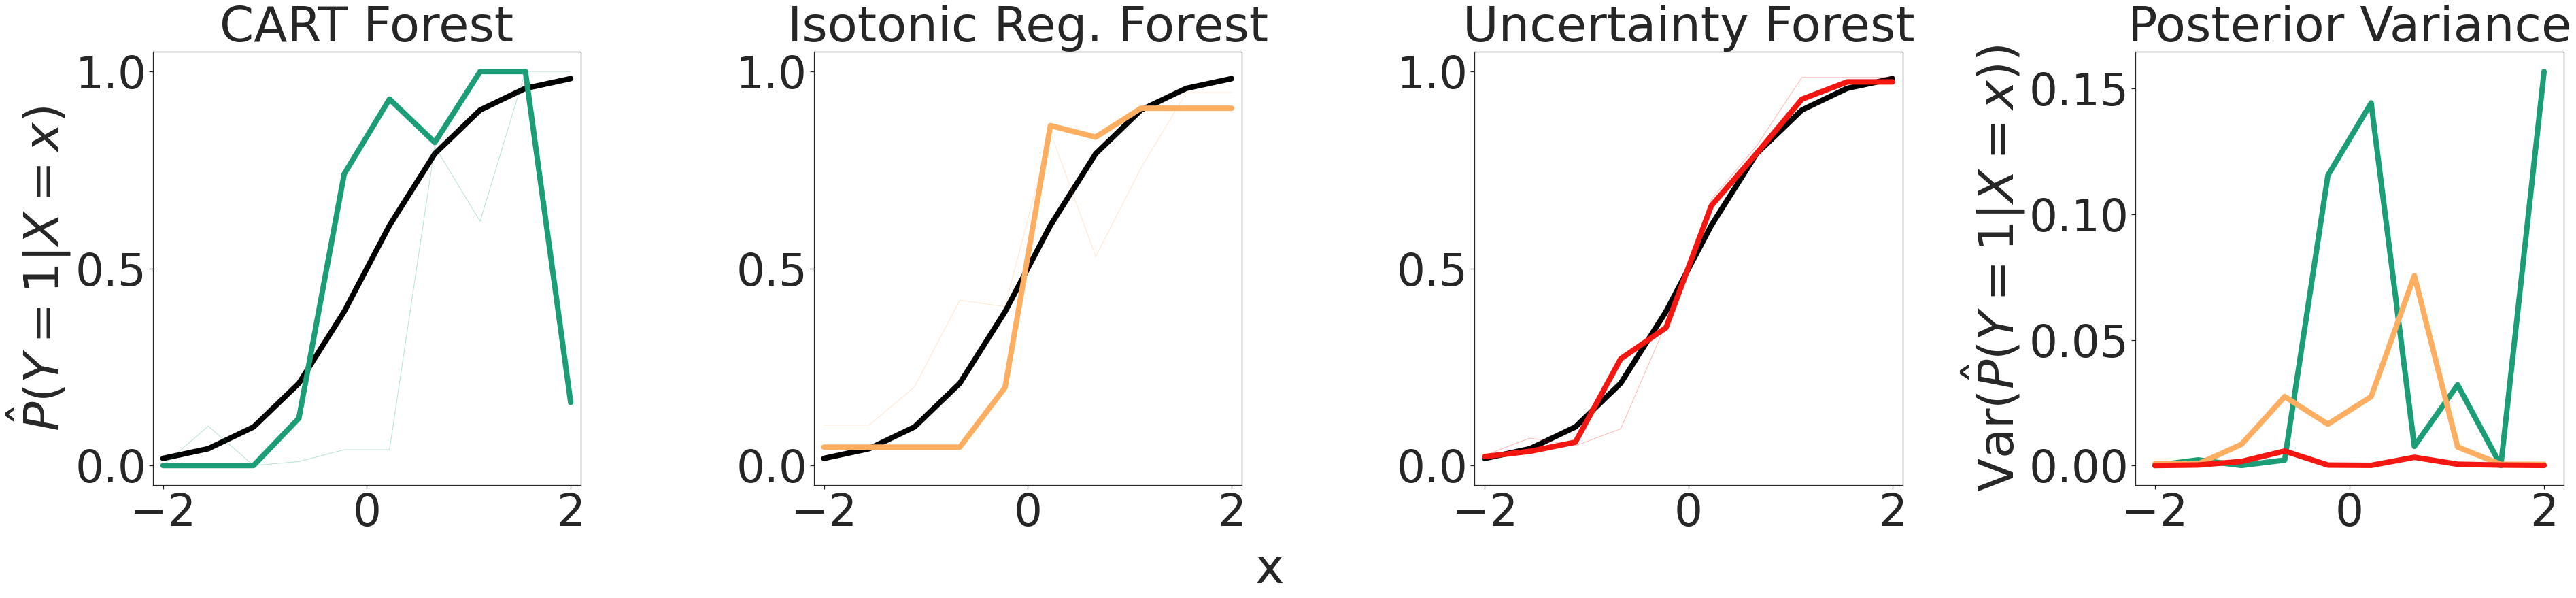

In [87]:
plot_fig1(algos, num_plotted_trials, X_eval, n, mean, var)

In [88]:
# https://nbviewer.jupyter.org/github/rflperry/ProgLearn/blob/UF/benchmarks/uf_experiments/cc18/profile_speeds.ipynb

uf = UncertaintyForest(
        n_estimators=100,
        tree_construction_proportion=0.63,
        kappa=np.inf,
        honest_prior="ignore"
    )

rf = RandomForestClassifier(n_estimators=100)

results = []


for n in [100, 1000, 10000]:
    print(n)
    n_list = []
    d = 50
    X = np.random.normal(0, 1, (n, d))
    y = np.random.binomial(1, 0.5, n)
    
    # RF fit, predict
    time = %timeit -n 1 -o rf.fit(X, y)
    n_list.append(np.mean(time.timings))
    time = %timeit -n 1 -o rf.predict_proba(X)
    n_list.append(np.mean(time.timings))
    
    # UF fit, predict
    time = %timeit -n 1 -o uf.fit(X, y)
    n_list.append(np.mean(time.timings))
    time = %timeit -n 1 -o uf.predict_proba(X)
    n_list.append(np.mean(time.timings))

    results.append(n_list)



100
195 ms ± 29.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12.5 ms ± 1.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
101 ms ± 8.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12.6 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1000
1.09 s ± 165 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
37.4 ms ± 3.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
631 ms ± 27.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
37.4 ms ± 3.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10000
9.27 s ± 226 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
249 ms ± 5.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.2 s ± 936 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
337 ms ± 4.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


[[ 0.19453417  0.01253126  0.10101453  0.01255757]
 [ 1.08990049  0.03741001  0.63091357  0.03740273]
 [ 9.27287769  0.24940467 11.15481203  0.33687927]]


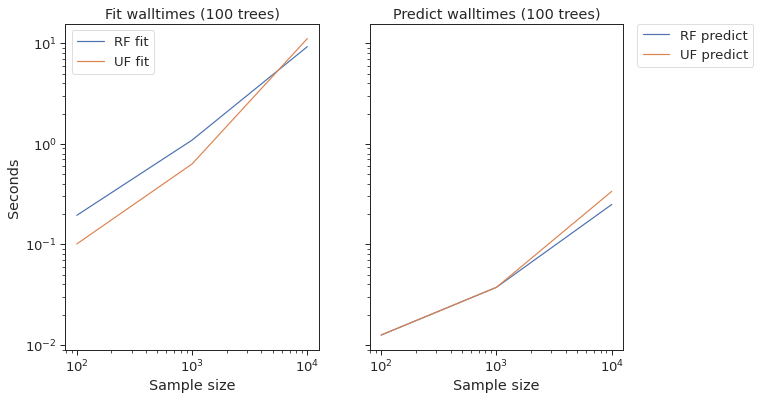

In [89]:
sns.set_context("paper", font_scale=1.5)   


ns = [100, 1000, 10000]
columns = [
    'RF fit',
    'RF predict',
    'UF fit',
    'UF predict',
]
means = np.asarray(results)

print(means)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), facecolor='white', sharey=True, sharex=True)

for col, label in enumerate(columns):
    if 'fit' in label:
        ax1.plot(ns, means[:, col], label=label)

ax1.legend()
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title('Fit walltimes (100 trees)')
ax1.set_ylabel('Seconds')
ax1.set_xlabel('Sample size')

for col, label in enumerate(columns):
    if 'predict' in label:
        ax2.plot(ns, means[:, col], label=label)

ax2.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02))
ax2.set_xscale('log')
ax2.set_xscale('log')
ax2.set_title('Predict walltimes (100 trees)')
ax2.set_xlabel('Sample size')

# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02))

# plt.ylabel('seconds')
plt.show()